Football Pitch Class Defined from <https://blog.roboflow.com/camera-calibration-sports-computer-vision/#using-keypoint-detection-models>

In [ ]:
!pip install mplsoccer
!pip install statsbombpy
!pip install inference
!pip install supervision
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install sklearn
!pip install cv2
!pip install dataclasses
!pip install typing


In [48]:
import cv2
import numpy as np
import supervision as sv
from inference import get_model
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from dataclasses import dataclass, field
from typing import List, Tuple
import pandas as pd
from sklearn.linear_model import LogisticRegression
import supervision as sv

# Define ViewTransformer class (same as before)
class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        if source.shape != target.shape:
            raise ValueError("Source and target must have the same shape.")
        if source.shape[1] != 2:
            raise ValueError("Source and target points must be 2D coordinates.")

        source = source.astype(np.float32)
        target = target.astype(np.float32)

        self.m, _ = cv2.findHomography(source, target)
        if self.m is None:
            raise ValueError("Homography matrix could not be calculated.")

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        if points.shape[1] != 2:
            raise ValueError("Points must be 2D coordinates.")

        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        return points.reshape(-1, 2).astype(np.float32)


# Define SoccerPitchConfiguration class
class SoccerPitchConfiguration:
    width: int = 7000  # [cm]
    length: int = 12000  # [cm]
    penalty_box_width: int = 4100  # [cm]
    penalty_box_length: int = 2015  # [cm]
    goal_box_width: int = 1832  # [cm]
    goal_box_length: int = 550  # [cm]
    centre_circle_radius: int = 915  # [cm]
    penalty_spot_distance: int = 1100  # [cm]

    @property
    def vertices(self) -> List[Tuple[int, int]]:
        return [
            (0, 0),  # 1
            (0, (self.width - self.penalty_box_width) / 2),  # 2
            (0, (self.width - self.goal_box_width) / 2),  # 3
            (0, (self.width + self.goal_box_width) / 2),  # 4
            (0, (self.width + self.penalty_box_width) / 2),  # 5
            (0, self.width),  # 6
            (self.goal_box_length, (self.width - self.goal_box_width) / 2),  # 7
            (self.goal_box_length, (self.width + self.goal_box_width) / 2),  # 8
            (self.penalty_spot_distance, self.width / 2),  # 9
            (self.penalty_box_length, (self.width - self.penalty_box_width) / 2),  # 10
            (self.penalty_box_length, (self.width - self.goal_box_width) / 2),  # 11
            (self.penalty_box_length, (self.width + self.goal_box_width) / 2),  # 12
            (self.penalty_box_length, (self.width + self.penalty_box_width) / 2),  # 13
            (self.length / 2, 0),  # 14
            (self.length / 2, self.width / 2 - self.centre_circle_radius),  # 15
            (self.length / 2, self.width / 2 + self.centre_circle_radius),  # 16
            (self.length / 2, self.width),  # 17
            (
                self.length - self.penalty_box_length,
                (self.width - self.penalty_box_width) / 2
            ),  # 18
            (
                self.length - self.penalty_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 19
            (
                self.length - self.penalty_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 20
            (
                self.length - self.penalty_box_length,
                (self.width + self.penalty_box_width) / 2
            ),  # 21
            (self.length - self.penalty_spot_distance, self.width / 2),  # 22
            (
                self.length - self.goal_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 23
            (
                self.length - self.goal_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 24
            (self.length, 0),  # 25
            (self.length, (self.width - self.penalty_box_width) / 2),  # 26
            (self.length, (self.width - self.goal_box_width) / 2),  # 27
            (self.length, (self.width + self.goal_box_width) / 2),  # 28
            (self.length, (self.width + self.penalty_box_width) / 2),  # 29
            (self.length, self.width),  # 30
            (self.length / 2 - self.centre_circle_radius, self.width / 2),  # 31
            (self.length / 2 + self.centre_circle_radius, self.width / 2),  # 32
        ]

    edges: List[Tuple[int, int]] = field(default_factory=lambda: [
        (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (7, 8),
        (10, 11), (11, 12), (12, 13), (14, 15), (15, 16),
        (16, 17), (18, 19), (19, 20), (20, 21), (23, 24),
        (25, 26), (26, 27), (27, 28), (28, 29), (29, 30),
        (1, 14), (2, 10), (3, 7), (4, 8), (5, 13), (6, 17),
        (14, 25), (18, 26), (23, 27), (24, 28), (21, 29), (17, 30)
    ])

    labels: List[str] = field(default_factory=lambda: [
        "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
        "11", "12", "13", "15", "16", "17", "18", "20", "21", "22",
        "23", "24", "25", "26", "27", "28", "29", "30", "31", "32",
        "14", "19"
    ])

    colors: List[str] = field(default_factory=lambda: [
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#00BFFF", "#00BFFF", "#00BFFF", "#00BFFF", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#00BFFF", "#00BFFF"
    ])

We load a pre-trained pitch detection keypoints model and player detection model we found from the same blog as above.

In [130]:
# Load pre-trained models from the same blog
pitch_detection_model = get_model(
    model_id="football-field-detection-f07vi/14", 
    api_key=""
)

player_detection_model = get_model(
    model_id="football-players-detection-3zvbc/10", 
    api_key=""
)

# Load image
image_path = "Shot1.jpg"
frame = cv2.imread(image_path)

# Detect pitch
pitch_result = pitch_detection_model.infer(frame, confidence=0.3)[0]
pitch_keypoints = sv.KeyPoints.from_inference(pitch_result)

# Filter keypoints
filter = pitch_keypoints.confidence[0] > 0.5
pitch_keypoints.xy = pitch_keypoints.xy[0][filter][np.newaxis]
pitch_keypoints.confidence = pitch_keypoints.confidence[0][filter][np.newaxis]

# Annotate pitch keypoints
vertex_annotator = sv.VertexAnnotator(radius=12)
annotated_image = vertex_annotator.annotate(frame.copy(), pitch_keypoints)

# Detect players
player_result = player_detection_model.infer(frame, confidence=0.3)[0]
player_detections = sv.Detections.from_inference(player_result)

# Annotate players
ellipse_annotator = sv.EllipseAnnotator(thickness=2)
annotated_image = ellipse_annotator.annotate(annotated_image, player_detections)

# Transform player coordinates
CONFIG = SoccerPitchConfiguration()
transformer = ViewTransformer(
    source=pitch_keypoints.xy[0].astype(np.float32),
    target=np.array(CONFIG.vertices)[filter].astype(np.float32)
)

player_xy = player_detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
transformed_xy = transformer.transform_points(player_xy)
print(f"Transformed player coordinates: {transformed_xy}")

def flip_x_coordinate(x):
    return CONFIG.length - x

# Function to calculate distance to goal
def distance_to_goal(x: float, y: float) -> float:
    """
    Calculate the Euclidean distance from the shot location to the center of the goal.

    Args:
        x (float): x-coordinate of the shot.
        y (float): y-coordinate of the shot.

    Returns:
        float: Distance in meters.
    """
    x_meters = x
    x_flipped = CONFIG.length - x_meters
    goal_x = CONFIG.length  # Assuming the goal is at the end of the pitch
    goal_y = CONFIG.width / 2
    distance_cm = np.sqrt((goal_x - x_flipped)**2 + (goal_y - y)**2)
    return distance_cm / 100

# Function to calculate angle to goal
def angle_to_goal(x, y):
    # Convert player position to meters
    x_meters = x
    y_meters = y

    # Define goal dimensions and positions in meters
    goal_width = 7.32  # meters
    goal_length = CONFIG.length  # Convert cm to meters
    goal_center_x = goal_length  # Assuming goal is at the far end
    goal_center_y = (CONFIG.width) / 2  # Center of the pitch in meters

    # Positions of the goal posts
    left_post = (goal_center_x, goal_center_y - goal_width / 2)
    right_post = (goal_center_x, goal_center_y + goal_width / 2)

    # Vectors from player to goal posts
    vector_left = np.array([left_post[0] - x_meters, left_post[1] - y_meters])
    vector_right = np.array([right_post[0] - x_meters, right_post[1] - y_meters])

    # Calculate the angle between the two vectors
    unit_vector_left = vector_left / np.linalg.norm(vector_left)
    unit_vector_right = vector_right / np.linalg.norm(vector_right)
    dot_product = np.dot(unit_vector_left, unit_vector_right)
    
    # Clamp the dot product to avoid numerical issues
    dot_product = np.clip(dot_product, -1.0, 1.0)
    
    angle_rad = np.arccos(dot_product)
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg


# Print transformed player coordinates
print("Transformed player coordinates:")
print(transformed_xy)

Transformed player coordinates: [[3152.2986 3787.8726]
 [2338.8396 5250.699 ]
 [3535.97   4131.06  ]
 [2335.9785 3809.852 ]
 [2416.6228 2051.6028]
 [2753.0083 1780.2438]
 [3115.9592 1957.3218]
 [2412.532  2624.5195]
 [3664.0115 3144.366 ]
 [4213.291  4014.767 ]
 [ 528.3451 3628.3267]
 [2306.379  4569.3906]
 [3591.2488 2993.6704]
 [2540.4617 4446.2104]
 [3328.8767 4095.683 ]
 [2609.2778  893.9352]]
Transformed player coordinates:
[[3152.2986 3787.8726]
 [2338.8396 5250.699 ]
 [3535.97   4131.06  ]
 [2335.9785 3809.852 ]
 [2416.6228 2051.6028]
 [2753.0083 1780.2438]
 [3115.9592 1957.3218]
 [2412.532  2624.5195]
 [3664.0115 3144.366 ]
 [4213.291  4014.767 ]
 [ 528.3451 3628.3267]
 [2306.379  4569.3906]
 [3591.2488 2993.6704]
 [2540.4617 4446.2104]
 [3328.8767 4095.683 ]
 [2609.2778  893.9352]]


We utilize a notebook found from <https://medium.com/@alf.19x/how-to-build-your-own-expected-goals-xg-model-2bd186dccdf7> that uses the mplsoccer package to train an XG model. I edited the code to change the competitions and seasons that are selected. 

In [28]:
import pandas as pd
import numpy as np
import math
from mplsoccer import Sbopen

pd.set_option('display.max_columns', 500)

# Initialize parser
parser = Sbopen()

# Get all competitions and seasons
competitions = parser.competition()

# Optional: Filter for men's competitions
competitions = competitions[competitions['competition_gender'] == 'male']

# Initialize DataFrame for shots
df_shot = pd.DataFrame(columns=['x', 'y', 'outcome_name', 'shot_statsbomb_xg'])

# Loop through each competition and season
for idx, competition in competitions.iterrows():
    competition_id = competition['competition_id']
    season_id = competition['season_id']
    print(f"Processing Competition ID {competition_id}, Season ID {season_id}")

    # Get matches for each competition and season
    df_match = parser.match(competition_id=competition_id, season_id=season_id)

    # Loop through each match
    for i, match_id in enumerate(df_match['match_id']):
        # Retrieve event data for each match
        events, related, freeze, tactics = parser.event(match_id)

        # Check if 'play_pattern_name' column exists
        if 'play_pattern_name' not in events.columns:
            print(f"'play_pattern_name' not found in match {match_id}. Skipping this match.")
            continue

        # Filter shots from open play in regular time (periods 1-4)
        mask_shot = (
            (events['type_name'] == 'Shot') &
            (events['period'] <= 4) &
            (events['play_pattern_name'] == 'Regular Play')  # Adjusted column name and value
        )

        shots_temp = events.loc[mask_shot, ['x', 'y', 'outcome_name', 'shot_statsbomb_xg']]

        # Append to df_shot
        df_shot = pd.concat([df_shot, shots_temp], ignore_index=True)

# Drop rows with missing values in 'x' or 'y'
df_shot.dropna(subset=['x', 'y'], inplace=True)

# Define functions for angle and distance calculations
def calculate_angle(x, y):
    # Coordinates of goal posts
    goal_y1 = 36
    goal_y2 = 44
    goal_x = 120
    y = float(y)
    x = float(x)
    a = np.array([goal_x - x, goal_y1 - y])
    b = np.array([goal_x - x, goal_y2 - y])
    # Ensure the denominator is not zero
    denominator = np.linalg.norm(a) * np.linalg.norm(b)
    if denominator == 0:
        return 0
    angle = np.arccos(
        (np.dot(a, b)) / denominator
    )
    return np.degrees(angle)

def calculate_distance(x, y):
    # Center of goal
    goal_center_x = 120
    goal_center_y = 40
    return np.sqrt((goal_center_x - x)**2 + (goal_center_y - y)**2)

# Calculate angle and distance
df_shot['angle'] = df_shot.apply(lambda row: calculate_angle(row['x'], row['y']), axis=1)
df_shot['distance'] = df_shot.apply(lambda row: calculate_distance(row['x'], row['y']), axis=1)

# Create 'goal' column
df_shot['goal'] = df_shot['outcome_name'].apply(lambda x: 1 if x == 'Goal' else 0)

# Group by goal and calculate mean angle and distance
goal_stats = df_shot.groupby('goal').agg({
    'angle': 'mean',
    'distance': 'mean'
})

print(goal_stats)


Selected Competitions and Seasons:
   competition_id  competition_name  season_id season_name
0               9     1. Bundesliga        281   2023/2024
1               9     1. Bundesliga         27   2015/2016
3              16  Champions League          4   2018/2019
4              16  Champions League          1   2017/2018
5              16  Champions League          2   2016/2017
6              16  Champions League         27   2015/2016
8              16  Champions League         25   2013/2014

Processing Competition ID 9, Season ID 281

Processing Competition ID 9, Season ID 27

Processing Competition ID 16, Season ID 4

Processing Competition ID 16, Season ID 1

Processing Competition ID 16, Season ID 2

Processing Competition ID 16, Season ID 27

Processing Competition ID 16, Season ID 25

Goal Statistics:
          angle   distance
goal                      
0     21.862186  20.307178
1     38.859022  12.507085


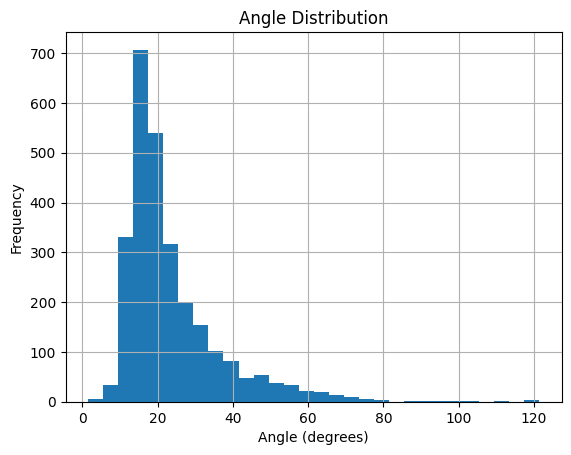

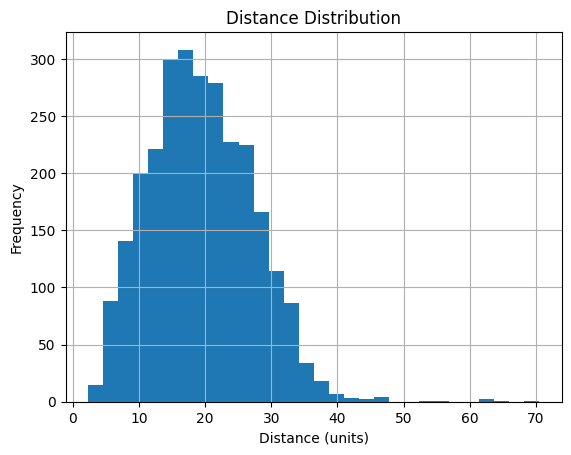

       x     y      angle   distance
0  114.6  33.5  37.941499   8.450444
1   89.2  42.5  14.704957  30.901294
2  105.4  45.1  27.626114  15.465122
3  113.1  27.5  16.374678  14.277955
4   97.5  40.8  20.137024  22.514218


In [92]:
import matplotlib.pyplot as plt

df_shot['angle'].hist(bins=30)
plt.title('Angle Distribution')
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.show()

df_shot['distance'].hist(bins=30)
plt.title('Distance Distribution')
plt.xlabel('Distance (units)')
plt.ylabel('Frequency')
plt.show()
print(df_shot[['x', 'y', 'angle', 'distance']].head())

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

model_names = ['Linear', 'Logistic']
models = {}
models['Linear'] = {}
models['Linear']['model'] = LinearRegression()
models['Logistic'] = {}
models['Logistic']['model'] = LogisticRegression()

X = df_shot[['angle', 'distance']]
y = df_shot['goal']

from sklearn import metrics
for mod in model_names:
  models[mod]['model'].fit(X, y)
  if mod == 'Logistic':
    models[mod]['y_pred'] = models[mod]['model'].predict_proba(X)[:, 1]
  else:
    models[mod]['y_pred'] = models[mod]['model'].predict(X)

  models[mod]['r2_score'] = metrics.r2_score(y, models[mod]['y_pred'])
  print("R2 of model {}: {}".format(mod, models[mod]['r2_score']))



R2 of model Linear: 0.15668596521363765
R2 of model Logistic: 0.16585965105201017


While I did create a lot of the functions earlier,from here forward would be my biggest contribution (own work).

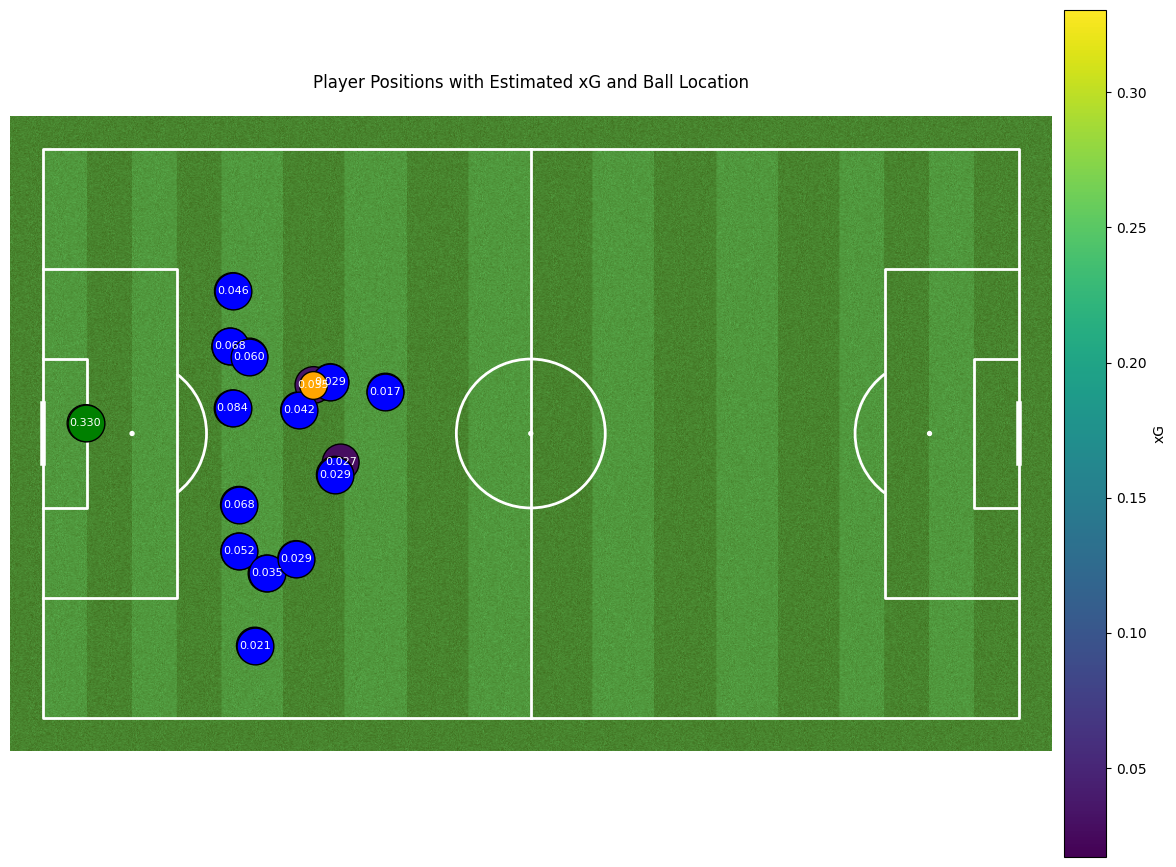

Player 1 xG: 0.042
Player 2 xG: 0.046
Player 3 xG: 0.029
Player 4 xG: 0.084
Player 5 xG: 0.052
Player 6 xG: 0.035
Player 7 xG: 0.029
Player 8 xG: 0.068
Player 10 xG: 0.017
Goalkeeper xG: 0.330
Player 12 xG: 0.068
Player 13 xG: 0.029
Player 14 xG: 0.060
Ball xG: 0.035
Player 16 xG: 0.021


In [134]:
# Function to load and train the xG model
def load_xg_model():
    # Verify that df_shot has been loaded correctly
    if df_shot.empty:
        raise ValueError("df_shot DataFrame is empty. Please check the data source.")
    if not {'distance', 'angle', 'goal'}.issubset(df_shot.columns):
        raise ValueError("df_shot must contain 'distance', 'angle', and 'goal' columns.")
        
    X = df_shot[['distance', 'angle']]
    y = df_shot['goal']
    
    model = LogisticRegression()
    model.fit(X, y)
    
    return model

xg_model = load_xg_model()

# Function to calculate xG using the loaded model
def calculate_xg(distance, angle):
    return xg_model.predict_proba([[distance, angle]])[0][1]

# Calculate xG for each player
xg_values = []
for x, y in transformed_xy:
    distance = distance_to_goal(x, y)
    angle = angle_to_goal(x, y) * 1000       
    xg = calculate_xg(distance, angle)
    xg_values.append(xg)

# Convert coordinates to mplsoccer format (0-100 range)
# Instead, we use meters to match the actual field dimensions for consistency
x_coords = transformed_xy[:, 0] / 100  # Convert from cm to meters
y_coords = transformed_xy[:, 1] / 100  # Convert from cm to meters

# Create a pitch plot using the custom dimensions (converted from cm to meters)
pitch = Pitch(pitch_type='custom', pitch_length=CONFIG.length / 100, pitch_width=CONFIG.width / 100,
              pitch_color='grass', line_color='white', stripe=True)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

# Plot players with xG values
scatter = pitch.scatter(x_coords, y_coords, s=700, c=xg_values, cmap='viridis', edgecolors='black', ax=ax)
plt.colorbar(scatter, ax=ax, label='xG', pad=0.01)

# Add xG labels
for x, y, xg in zip(x_coords, y_coords, xg_values):
    pitch.annotate(f'{xg:.3f}', xy=(x, y), c='white', va='center', ha='center', size=8, ax=ax)

# Correctly identify and plot the ball, players, and goalkeeper without labels
for i, class_id in enumerate(player_detections.class_id):
    if class_id == 0:  # Ball
        ball_x, ball_y = x_coords[i], y_coords[i]
        pitch.scatter(ball_x, ball_y, s=400, c='orange', marker='o', edgecolors='black', ax=ax, zorder=2)
    elif class_id == 1:  # Goalkeeper
        pitch.scatter(x_coords[i], y_coords[i], s=700, c='green', edgecolors='black', ax=ax, zorder=2)
    elif class_id == 2:  # Players
        pitch.scatter(x_coords[i], y_coords[i], s=700, c='blue', edgecolors='black', ax=ax, zorder=2)

# Set title
ax.set_title('Player Positions with Estimated xG and Ball Location', pad=20)

# Show plot
plt.show()

# Print xG values
for i, (class_id, xg) in enumerate(zip(player_detections.class_id, xg_values)):
    if class_id == 0:  # Ball
        print(f"Ball xG: {xg:.3f}")
    elif class_id == 1:  # Goalkeeper
        print(f"Goalkeeper xG: {xg:.3f}")
    elif class_id == 2:  # Player
        print(f"Player {i+1} xG: {xg:.3f}")

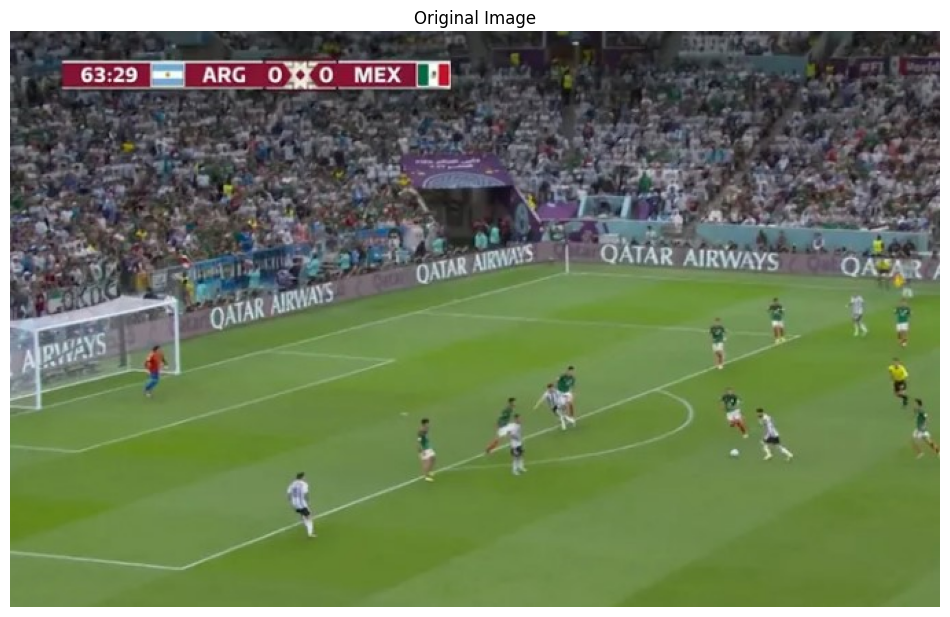

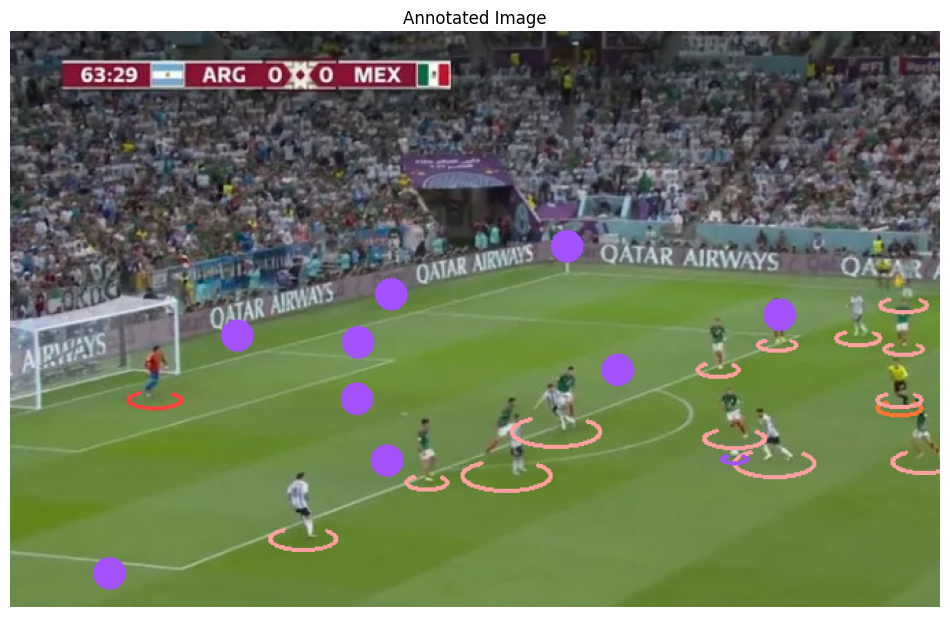

In [38]:
# Display the original image
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

# Display the annotated image
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title('Annotated Image')
plt.axis('off')
plt.show()